In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Input, Flatten, GlobalAveragePooling1D,Bidirectional, Dropout,GlobalMaxPooling1D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [ ]:
def capture(filename):
    frames = []
    vc = cv2.VideoCapture(filename)
    rval, frame = vc.read()
    while rval and len(frames) < 100:
        frame = cv2.resize(frame, (64, 64))
        frame = frame / 255.0
        frames.append(frame)
        rval, frame = vc.read()
    vc.release()
    return frames

def load_data_from_dir(data_dir, label, data_list, label_list, max_videos):
    video_count = 0
    for filename in os.listdir(data_dir):
        if filename.endswith('.mp4') and video_count < max_videos:
            file_path = os.path.join(data_dir, filename)
            frames = capture(file_path)
            if len(frames) == 100:
                data_list.append(frames)
                label_list.append(label)
                video_count += 1

In [ ]:
violent_data_dir = '/content/drive/MyDrive/dataset_V/Violence'
non_violent_data_dir = '/content/drive/MyDrive/dataset_V/NonViolence'

fights = []
labels = []

load_data_from_dir(violent_data_dir, 1, fights, labels, max_videos=995)
load_data_from_dir(non_violent_data_dir, 0, fights, labels, max_videos=995)

fights = np.array(fights)
labels = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fights, labels, test_size=0.1, random_state=42)

In [ ]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
input_tensor = Input(shape=(100, 64, 64, 3))

x = TimeDistributed(base_model)(input_tensor)
x = TimeDistributed(Flatten())(x)

x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.009)))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.009))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling1D()(x)

output = Dense(2, activation='sigmoid', kernel_regularizer=l2(0.009))(x)

model = Model(inputs=input_tensor,outputs=output)

In [ ]:
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-5, verbose=1, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5, min_lr=0.0000001)

In [ ]:
history = model.fit(X_train, y_train, batch_size=1, epochs=30, verbose=1, validation_split = 0.1, callbacks=[early_stopping, reduce_lr_loss])

Epoch 1/30
1464/1464 [==============================] - 177s 117ms/step - loss: 1.3322 - accuracy: 0.7275 - val_loss: 0.8434 - val_accuracy: 0.8160 - lr: 5.0000e-04
Epoch 2/30
1464/1464 [==============================] - 172s 117ms/step - loss: 0.8148 - accuracy: 0.7999 - val_loss: 0.7344 - val_accuracy: 0.8221 - lr: 5.0000e-04
Epoch 3/30
1464/1464 [==============================] - 169s 115ms/step - loss: 0.7027 - accuracy: 0.8245 - val_loss: 0.6631 - val_accuracy: 0.8221 - lr: 5.0000e-04
Epoch 4/30
1464/1464 [==============================] - 169s 116ms/step - loss: 0.6312 - accuracy: 0.8497 - val_loss: 0.6187 - val_accuracy: 0.8405 - lr: 5.0000e-04
Epoch 5/30
1464/1464 [==============================] - 168s 115ms/step - loss: 0.6094 - accuracy: 0.8552 - val_loss: 0.5852 - val_accuracy: 0.8589 - lr: 5.0000e-04
Epoch 6/30
1464/1464 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.8798
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1

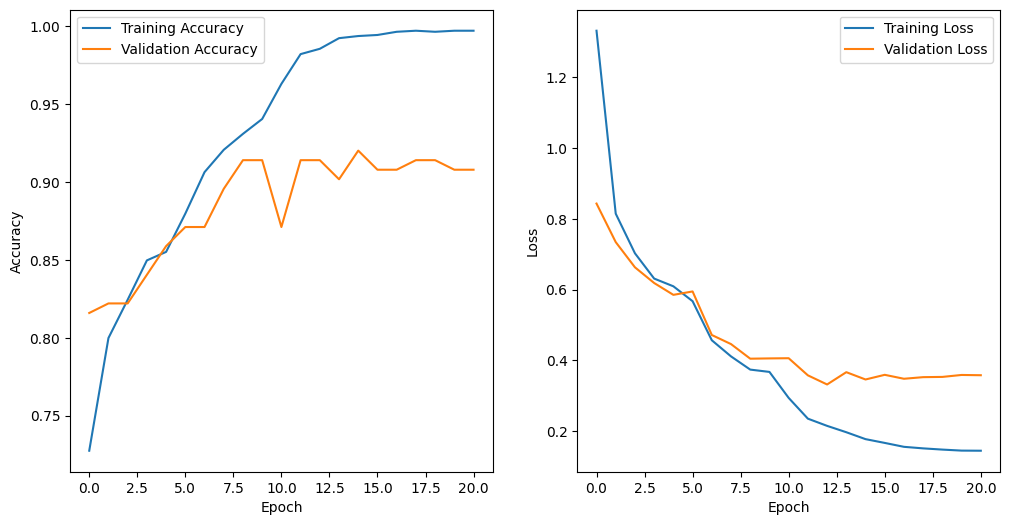

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 [==============================] - 14s 2s/step - loss: 0.5712 - accuracy: 0.8619
Test Loss: 0.5711644887924194
Test Accuracy: 0.8618784546852112


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

6/6 [==============================] - 15s 2s/step


Confusion Matrix:
[[72 10]
 [15 84]]


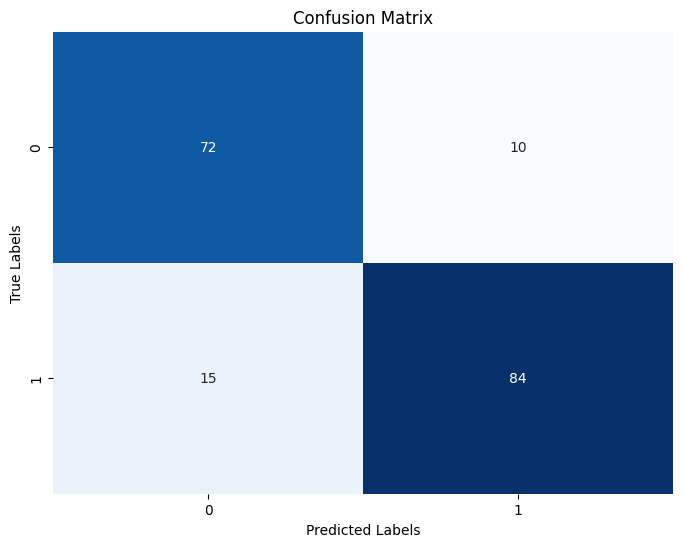

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['NonViolence', 'Violence']))

Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.83      0.88      0.85        82
    Violence       0.89      0.85      0.87        99

    accuracy                           0.86       181
   macro avg       0.86      0.86      0.86       181
weighted avg       0.86      0.86      0.86       181



In [ ]:
def capture_frames(filename, num_frames=100, frame_size=(64, 64)):
    frames = []
    vc = cv2.VideoCapture(filename)
    for _ in range(num_frames):
        rval, frame = vc.read()
        if not rval:
            break
        frame = cv2.resize(frame, frame_size).astype(np.float32) / 255.0
        frames.append(frame)
    vc.release()
    return np.array(frames)

def predict_violence(model, video_frames, threshold=0.5):
    video_data = np.expand_dims(video_frames, axis=0)
    predictions = model.predict(video_data)
    violence_probability = predictions[0][1]
    is_violent = violence_probability >= threshold
    return is_violent, violence_probability

def process_video(model, video_file_path, num_frames=100, frame_size=(64, 64), threshold=0.5):
    video_frames = capture_frames(video_file_path, num_frames, frame_size)
    is_violent, confidence = predict_violence(model, video_frames, threshold)
    result = {
        'violence': is_violent,
        'violence_estimation': str(confidence),
        'video_file_path': video_file_path
    }
    return result

video_file_path_1 = "/content/drive/MyDrive/dataset_V/Violence/V_998.mp4"
video_file_path_2 = "/content/drive/MyDrive/dataset_V/NonViolence/NV_998.mp4"

result_1 = process_video(model, video_file_path_1)
print("Violent Video Prediction Result:", result_1)

result_2 = process_video(model, video_file_path_2)
print("Non-Violent Video Prediction Result:", result_2)

1/1 [==============================] - 0s 91ms/step
Violent Video Prediction Result: {'violence': True, 'violence_estimation': '0.9262608', 'video_file_path': '/content/drive/MyDrive/dataset_V/Violence/V_998.mp4'}
1/1 [==============================] - 0s 85ms/step
Non-Violent Video Prediction Result: {'violence': False, 'violence_estimation': '0.019298354', 'video_file_path': '/content/drive/MyDrive/dataset_V/NonViolence/NV_998.mp4'}


In [ ]:
model.save_weights('weights2/model_weights2')

In [ ]:
!cp -r /content/weights2/ /content/drive/MyDrive/

In [ ]:
!cp -r /content/drive/MyDrive/weights2/ /content/weights2/

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Input, Flatten, GlobalAveragePooling1D,Bidirectional, Dropout,GlobalMaxPooling1D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [ ]:
def capture(filename):
    frames = []
    vc = cv2.VideoCapture(filename)
    rval, frame = vc.read()
    while rval and len(frames) < 100:
        frame = cv2.resize(frame, (64, 64))
        frame = frame / 255.0
        frames.append(frame)
        rval, frame = vc.read()
    vc.release()
    return frames

def load_data_from_dir(data_dir, label, data_list, label_list, max_videos):
    video_count = 0
    for filename in os.listdir(data_dir):
        if filename.endswith('.mp4') and video_count < max_videos:
            file_path = os.path.join(data_dir, filename)
            frames = capture(file_path)
            if len(frames) == 100:
                data_list.append(frames)
                label_list.append(label)
                video_count += 1

In [ ]:
violent_data_dir = '/content/drive/MyDrive/dataset_V/Violence'
non_violent_data_dir = '/content/drive/MyDrive/dataset_V/NonViolence'

fights = []
labels = []

load_data_from_dir(violent_data_dir, 1, fights, labels, max_videos=100)
load_data_from_dir(non_violent_data_dir, 0, fights, labels, max_videos=100)

fights = np.array(fights)
labels = np.array(labels)

In [ ]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_model.trainable = False

In [ ]:
input_tensor = Input(shape=(100, 64, 64, 3))

x = TimeDistributed(base_model)(input_tensor)
x = TimeDistributed(Flatten())(x)

x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.009)))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.009))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling1D()(x)

output = Dense(2, activation='sigmoid', kernel_regularizer=l2(0.009))(x)

In [ ]:
Trained_model = Model(inputs=input_tensor,outputs=output)
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
Trained_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
Trained_model.load_weights('weights2/weights2/model_weights2')
Trained_test_loss, Trained_test_accuracy = Trained_model.evaluate(fights, labels)
print(f"Test Loss: {Trained_test_loss}")
print(f"Test Accuracy: {Trained_test_accuracy}")

7/7 [==============================] - 93s 12s/step - loss: 0.1857 - accuracy: 0.9800
Test Loss: 0.1857408732175827
Test Accuracy: 0.9800000190734863


In [ ]:
y_pred = Trained_model.predict(fights)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 96s 12s/step


Confusion Matrix:
[[99  1]
 [ 3 97]]


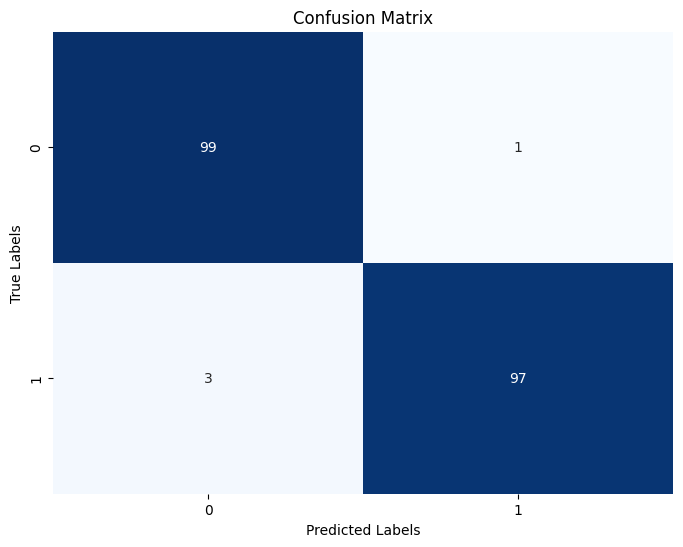

In [ ]:
cm = confusion_matrix(labels, y_pred_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def capture_frames(filename, num_frames=100, frame_size=(64, 64)):
    frames = []
    vc = cv2.VideoCapture(filename)
    for _ in range(num_frames):
        rval, frame = vc.read()
        if not rval:
            break
        frame = cv2.resize(frame, frame_size).astype(np.float32) / 255.0
        frames.append(frame)
    vc.release()
    return np.array(frames)

def predict_violence(model, video_frames, threshold=0.5):
    video_data = np.expand_dims(video_frames, axis=0)
    predictions = model.predict(video_data)
    violence_probability = predictions[0][1]
    is_violent = violence_probability >= threshold
    return is_violent, violence_probability

def process_video(model, video_file_path, num_frames=100, frame_size=(64, 64), threshold=0.5):
    video_frames = capture_frames(video_file_path, num_frames, frame_size)
    is_violent, confidence = predict_violence(model, video_frames, threshold)
    result = {
        'violence': is_violent,
        'violence_estimation': str(confidence),
        'video_file_path': video_file_path
    }
    return result

video_file_path_1 = "/content/drive/MyDrive/dataset_V/Violence/V_998.mp4"
video_file_path_2 = "/content/drive/MyDrive/dataset_V/NonViolence/NV_998.mp4"

result_1 = process_video(Trained_model, video_file_path_1)
print("Violent Video Prediction Result:", result_1)

result_2 = process_video(Trained_model, video_file_path_2)
print("Non-Violent Video Prediction Result:", result_2)

1/1 [==============================] - 0s 444ms/step
Violent Video Prediction Result: {'violence': True, 'violence_estimation': '0.9262607', 'video_file_path': '/content/drive/MyDrive/dataset_V/Violence/V_998.mp4'}
1/1 [==============================] - 1s 599ms/step
Non-Violent Video Prediction Result: {'violence': False, 'violence_estimation': '0.019298363', 'video_file_path': '/content/drive/MyDrive/dataset_V/NonViolence/NV_998.mp4'}
